In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import yaml
import open3d as o3d
from tqdm.notebook import tqdm

# Add the project directory to the Python path
sys.path.append('..')

# Import project modules
from src.preprocessing.image_loader import load_image_sequence, resize_images
from src.preprocessing.image_preprocessing import enhance_contrast
from src.feature_extraction.sift_extractor import extract_features_from_image_set
from src.feature_extraction.feature_matcher import match_image_pairs, geometric_verification
from src.sfm.camera_calibration import estimate_camera_matrix
from src.sfm.pose_estimation import estimate_poses_incremental, force_loop_closure
from src.sfm.triangulation import triangulate_all_points, merge_triangulated_points
from src.sfm.bundle_adjustment import run_global_ba
from src.dense_reconstruction.mvs import process_mvs
from src.dense_reconstruction.point_cloud import process_dense_reconstruction
from src.surface_reconstruction.mesh_generation import process_point_cloud_to_mesh
from src.surface_reconstruction.texture_mapping import create_textured_mesh_from_point_cloud

from src.visualization.plot_matches import plot_matches, plot_feature_matching_analysis
from src.visualization.point_cloud_visualizer import plot_interactive_point_cloud, create_point_cloud_animation
from src.visualization.camera_visualizer import plot_interactive_camera_poses
from src.visualization.mesh_visualizer import visualize_mesh_o3d, plot_interactive_mesh

# Set up matplotlib for inline display
%matplotlib inline
# For newer matplotlib versions (3.6+)
plt.style.use('default')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
# Define configuration
config = {
    'preprocessing': {
        'resize_max_dimension': 1000,
        'enhance_contrast': True
    },
    'features': {
        'method': 'sift',  # 'sift', 'surf', or 'orb'
        'max_features': 15000,  # Increased significantly
        'contrast_threshold': 0.01,  # Lower threshold to get more features (default is 0.04)
        'edge_threshold': 15,  # Higher to detect more features on edges (default is 10)
        'sigma': 1.6  # Standard sigma value
    },
    'matching': {
        'ratio_threshold': 0.8,  # Slightly more permissive
        'geometric_verification': True,
        'min_matches': 12,
        'verification_method': 'fundamental',  # 'fundamental' or 'homography'
        'ransac_threshold': 3.0
    },
    'calibration': {
        'focal_length_factor': 1.2  # Focal length = factor * max(width, height)
    },
    'sfm': {
        'incremental': True,
        'refine_poses': True,
        'min_triangulation_angle_deg': 3.0,
        'reprojection_error_threshold': 4.0
    },
    'mvs': {
        'min_disparity': 0,
        'num_disparities': 128,  # Increased for better depth capture
        'block_size': 9,  # Increased for better matching on low-texture regions
        'filter_depths': True,
        'consistency_threshold': 0.02,  # More permissive (was 0.01)
        'num_source_views': 3  # Use more views (was 2)
    },
    'point_cloud': {
        'voxel_size': 0.01,
        'nb_neighbors': 20,
        'std_ratio': 2.0,
        'confidence_threshold': 0.3  # More permissive (was 0.5)
    },
    'surface': {
        'method': 'poisson',  # 'poisson', 'ball_pivoting', or 'alpha_shape'
        'depth': 9,
        'cleanup': True
    },
    'visualization': {
        'point_size': 2,
        'camera_size': 6,
        'point_color_method': 'rgb'  # 'rgb', 'depth', or 'normal'
    }
}

# Create output directory for results
output_dir = "../data/results/"
os.makedirs(output_dir, exist_ok=True)

print("Configuration loaded and output directory created.")

Configuration loaded and output directory created.


Loading images...
Loaded 36 images.
Resized images to maximum dimension of 1000 pixels.
Enhanced image contrast.


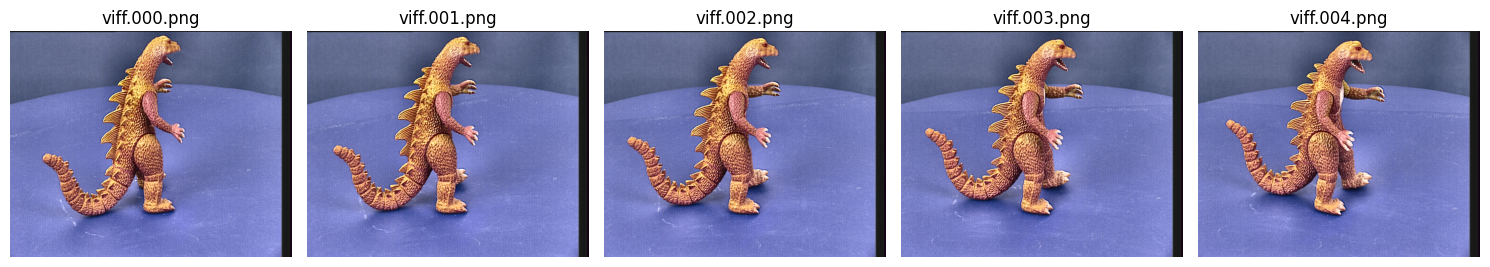

In [7]:
# Define path to dinosaur dataset
dataset_path = '../data/dinosaur/'

# Load images
print("Loading images...")
images = load_image_sequence(dataset_path, pattern="viff.*.png")
print(f"Loaded {len(images)} images.")

# Resize images if needed
max_dim = config['preprocessing']['resize_max_dimension']
images = resize_images(images, max_dimension=max_dim)
print(f"Resized images to maximum dimension of {max_dim} pixels.")

# Enhance contrast if specified
if config['preprocessing']['enhance_contrast']:
    images = enhance_contrast(images)
    print("Enhanced image contrast.")

# Display a subset of the images
n_images = min(5, len(images))
fig, axes = plt.subplots(1, n_images, figsize=(15, 5))

for i in range(n_images):
    img, filename = images[i]
    axes[i].imshow(img)
    axes[i].set_title(filename)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Extracting features from images...
viff.000.png: 1852 keypoints
viff.001.png: 1887 keypoints
viff.002.png: 1820 keypoints
viff.003.png: 1892 keypoints
viff.004.png: 1711 keypoints
viff.005.png: 1641 keypoints
viff.006.png: 1631 keypoints
viff.007.png: 1580 keypoints
viff.008.png: 1482 keypoints
viff.009.png: 1305 keypoints
viff.010.png: 1131 keypoints
viff.011.png: 1088 keypoints
viff.012.png: 1064 keypoints
viff.013.png: 1091 keypoints
viff.014.png: 1108 keypoints
viff.015.png: 1279 keypoints
viff.016.png: 1339 keypoints
viff.017.png: 1535 keypoints
viff.018.png: 1642 keypoints
viff.019.png: 1771 keypoints
viff.020.png: 1890 keypoints
viff.021.png: 1923 keypoints
viff.022.png: 1971 keypoints
viff.023.png: 2007 keypoints
viff.024.png: 2100 keypoints
viff.025.png: 2032 keypoints
viff.026.png: 1893 keypoints
viff.027.png: 1882 keypoints
viff.028.png: 1720 keypoints
viff.029.png: 1560 keypoints
viff.030.png: 1559 keypoints
viff.031.png: 1518 keypoints
viff.032.png: 1694 keypoints
viff.03

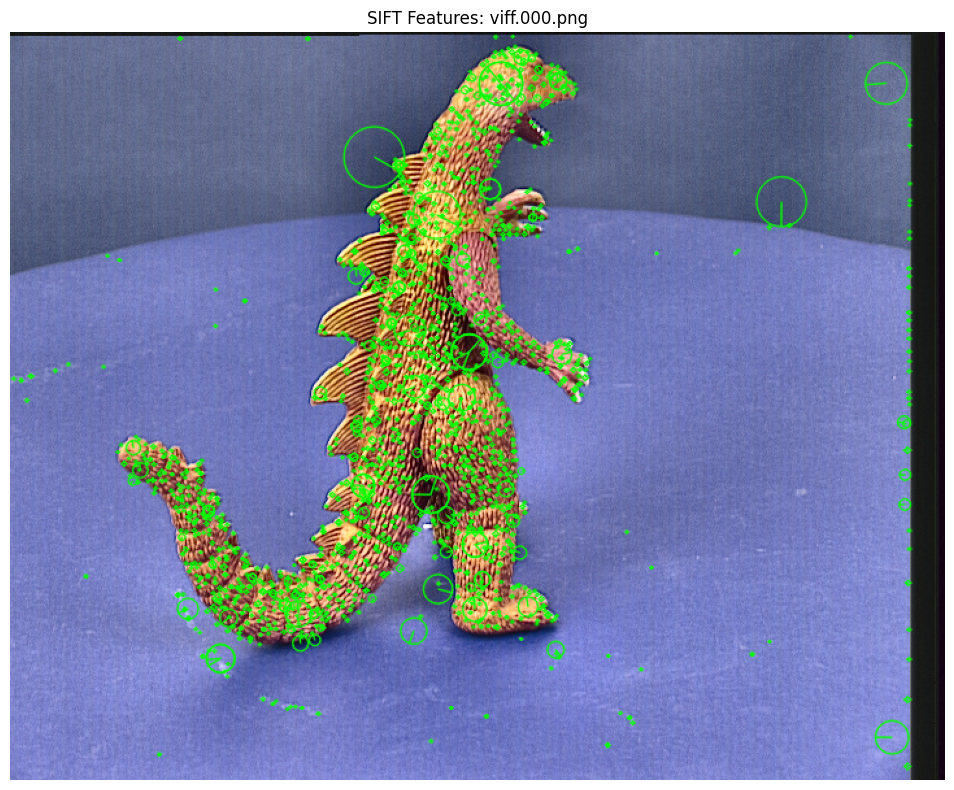


Matching features between image pairs...
Created 171 image pairs for matching
Successfully matched 170 image pairs.


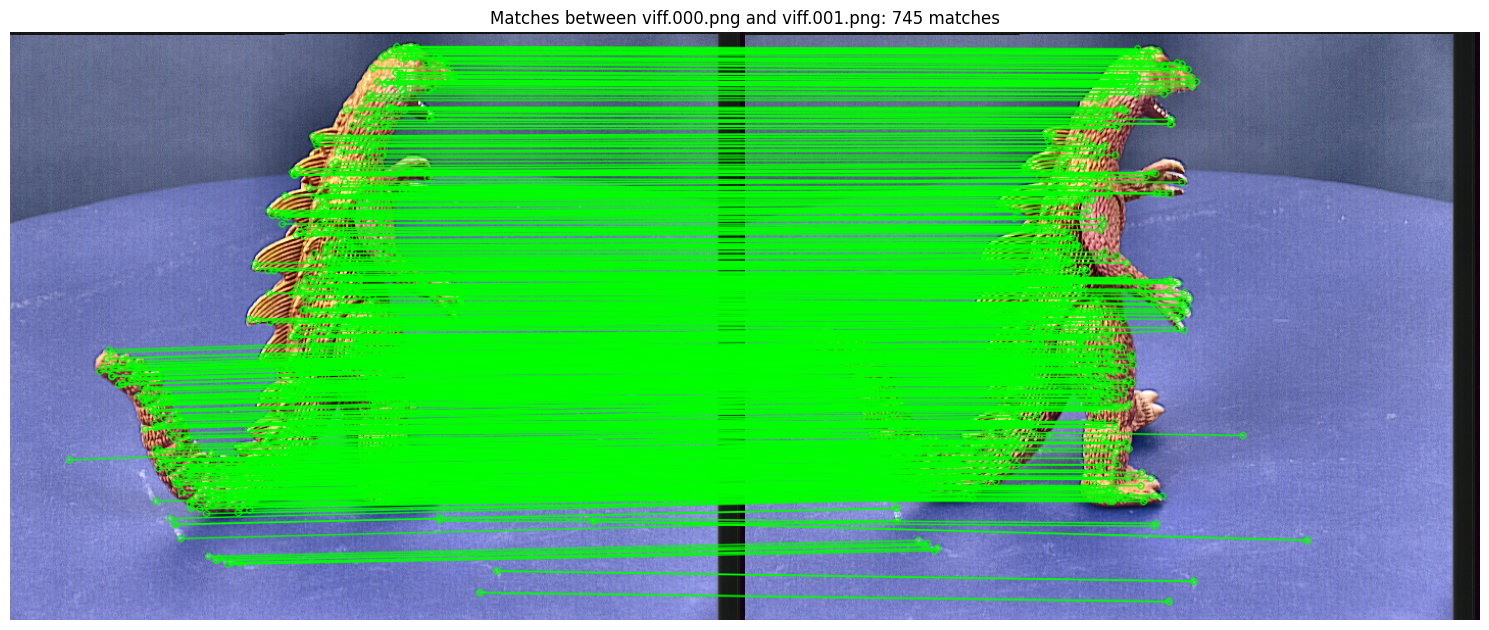

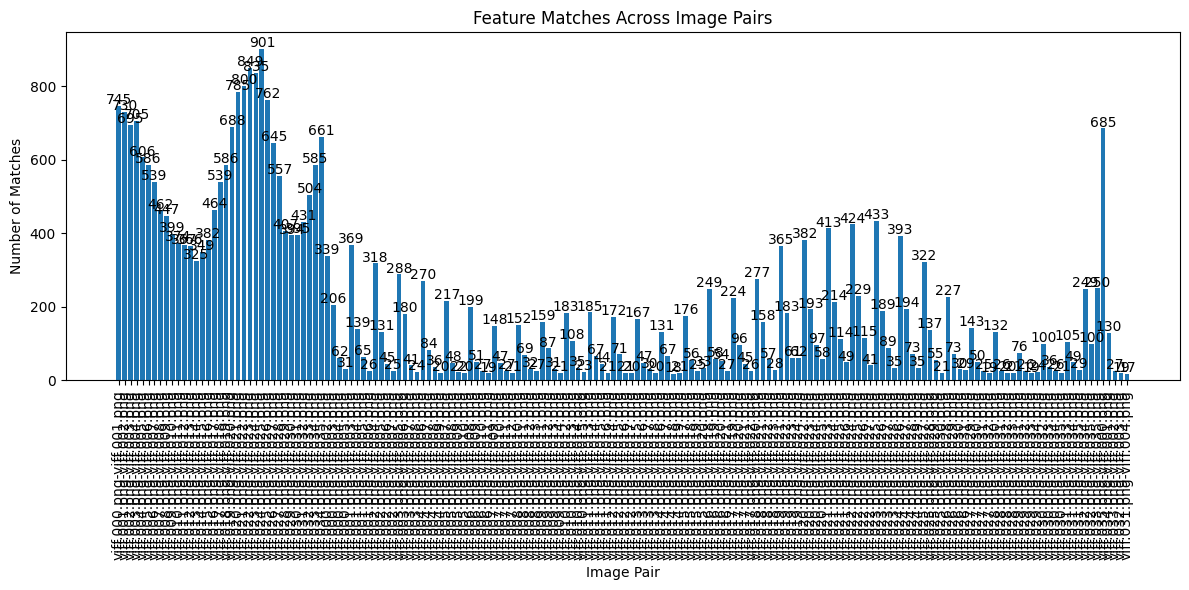

In [8]:
# Extract features
print("\nExtracting features from images...")
feature_method = config['features']['method']
max_features = config['features']['max_features']

features_dict = extract_features_from_image_set(images, method=feature_method, n_features=max_features)

# Print feature counts
for filename, (keypoints, descriptors) in features_dict.items():
    print(f"{filename}: {len(keypoints)} keypoints")

# Visualize keypoints on a sample image
sample_img, sample_filename = images[0]
sample_keypoints, _ = features_dict[sample_filename]

# Plot keypoints
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cv2.drawKeypoints(sample_img, sample_keypoints, None, 
                          color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
ax.set_title(f"{feature_method.upper()} Features: {sample_filename}")
ax.axis('off')
plt.tight_layout()
plt.show()

# Match features between consecutive image pairs plus loop closure
print("\nMatching features between image pairs...")
# Sort filenames to ensure consistent ordering
filenames = sorted([filename for _, filename in images], 
                  key=lambda x: int(''.join(filter(str.isdigit, x))))

# Create image pairs for matching
image_pairs = []
# Add consecutive pairs for sequential structure
for i in range(len(filenames)-1):
    image_pairs.append((filenames[i], filenames[i+1]))

# Add additional pairs for more robust reconstruction
for i in range(len(filenames)):
    # Match each image with several others
    for j in range(2, min(6, len(filenames)//2)):  # Try matching with images a few steps away
        if i + j < len(filenames):
            image_pairs.append((filenames[i], filenames[i+j]))

# Add explicit loop closure pairs
# Connect last few images with first few images
for i in range(min(5, len(filenames)//4)):
    image_pairs.append((filenames[-(i+1)], filenames[i]))

# Add the direct loop closure pair
image_pairs.append((filenames[-1], filenames[0]))

print(f"Created {len(image_pairs)} image pairs for matching")

# Match features
matches_dict = match_image_pairs(
    features_dict, 
    image_pairs, 
    config['matching']['ratio_threshold'],
    config['matching']['geometric_verification'],
    config['matching']['min_matches']
)

print(f"Successfully matched {len(matches_dict)} image pairs.")

# Display matches for a sample pair
if len(matches_dict) > 0:
    # Choose a sample pair
    sample_pair = list(matches_dict.keys())[0]
    img1_name, img2_name = sample_pair
    kp1, kp2, matches = matches_dict[sample_pair]
    
    # Get the images
    img1 = next(img for img, filename in images if filename == img1_name)
    img2 = next(img for img, filename in images if filename == img2_name)
    
    # Plot matches
    plot_matches(img1, kp1, img2, kp2, matches[:1000],  # Only plot first 1000 matches for clarity
                title=f"Matches between {img1_name} and {img2_name}: {len(matches)} matches")

    # Show matching statistics across all pairs
    plot_feature_matching_analysis(matches_dict, figsize=(12, 6))

In [9]:
# Estimate camera intrinsics
print("\nEstimating camera intrinsics...")
sample_img, _ = images[0]
image_shape = sample_img.shape
focal_length_factor = config['calibration']['focal_length_factor']
focal_length = focal_length_factor * max(image_shape[0], image_shape[1])
K = estimate_camera_matrix(image_shape, focal_length)

print("Estimated camera matrix:")
print(K)

# Estimate camera poses using incremental SfM
print("\nEstimating camera poses using Structure from Motion...")
camera_poses = estimate_poses_incremental(matches_dict, K, config['matching']['min_matches'])

print(f"Estimated poses for {len(camera_poses)} cameras.")

# Visualize camera poses
if len(camera_poses) > 0:
    # Extract camera positions for visualization (camera center is -R^T * t)
    camera_positions = {name: -R.T @ t for name, (R, t) in camera_poses.items()}
    
    # Plot camera positions
    plot_interactive_camera_poses(camera_poses)

# Apply loop closure correction
camera_poses = force_loop_closure(camera_poses)

# Visualize camera poses
if len(camera_poses) > 0:
    # Extract camera positions for visualization (camera center is -R^T * t)
    camera_positions = {name: -R.T @ t for name, (R, t) in camera_poses.items()}
    
    # Plot camera positions
    plot_interactive_camera_poses(camera_poses)


Estimating camera intrinsics...
Estimated camera matrix:
[[864.   0. 360.]
 [  0. 864. 288.]
 [  0.   0.   1.]]

Estimating camera poses using Structure from Motion...
Initializing with pair: viff.000.png and viff.001.png (745 matches)
Triangulated 744 initial points
Attempting to add image: viff.002.png
Found 634 2D-3D correspondences for viff.002.png
PnP successful with 618 inliers. Mean reprojection error: 1.22 pixels
Added pose for viff.002.png using 618 / 634 points
  Triangulated 83 new points with viff.000.png and viff.002.png
  Triangulated 341 new points with viff.001.png and viff.002.png
Attempting to add image: viff.003.png
Found 683 2D-3D correspondences for viff.003.png
PnP successful with 650 inliers. Mean reprojection error: 2.27 pixels
Added pose for viff.003.png using 650 / 683 points
  Triangulated 39 new points with viff.000.png and viff.003.png
  Triangulated 53 new points with viff.001.png and viff.003.png
  Triangulated 475 new points with viff.002.png and viff.0

Loop closure drift: 13.4680 units
Average distance between consecutive cameras: 1.8266 units
Applying enhanced loop closure correction
Enhanced loop closure correction applied


In [10]:
# Triangulate 3D points
print("\nTriangulating 3D points...")
points_3d, point_observations = triangulate_all_points(camera_poses, matches_dict, K)

print(f"Triangulated {len(points_3d)} 3D points.")

# Merge close points
merged_points, merged_observations = merge_triangulated_points(points_3d, point_observations)
print(f"After merging: {len(merged_points)} 3D points.")

# Bundle adjustment to refine camera poses and 3D points
if config['sfm']['refine_poses'] and len(merged_points) > 0:
    print("\nRunning bundle adjustment...")
    refined_poses, refined_points, _ = run_global_ba(camera_poses, matches_dict, K, iterations=50)
    camera_poses = refined_poses
    points_3d = refined_points
    print("Bundle adjustment complete.")

# Visualize sparse point cloud
if len(points_3d) > 0:
    print("\nVisualizing sparse point cloud...")
    points_array = np.array(points_3d)
    
    # Assign random colors for visualization
    np.random.seed(42)  # For reproducibility
    colors = np.random.rand(len(points_array), 3)
    
    # Interactive visualization
    plot_interactive_point_cloud(points_array, colors, title="Sparse 3D Reconstruction")

    # Save sparse point cloud
    sparse_cloud_file = os.path.join(output_dir, "dinosaur_sparse.ply")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_array)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.io.write_point_cloud(sparse_cloud_file, pcd)
    print(f"Saved sparse point cloud to {sparse_cloud_file}")


Triangulating 3D points...
Triangulating from 36 camera poses and 170 feature matches
Found 170 valid image pairs for triangulation
Triangulated 11430 3D points
Triangulated 11430 3D points.
Merged 11430 points into 10404 points
After merging: 10404 3D points.

Running bundle adjustment...
Triangulating from 36 camera poses and 170 feature matches
Found 170 valid image pairs for triangulation
Triangulated 11430 3D points
Merged 11430 points into 10404 points
Prepared 10404 points with at least 2 observations for bundle adjustment
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.7802e+04                                    7.40e+05    
       1              4         4.8603e+04      9.20e+03       3.54e+01       4.69e+05    
       2              5         6.4850e+03      4.21e+04       2.77e+01       3.59e+05    
       3              7         4.5216e+03      1.96e+03       1.30e+01       8.62e+04    
       4

Saved sparse point cloud to ../data/results/dinosaur_sparse.ply


In [12]:
# Define a function to isolate the dinosaur from the background
def isolate_dinosaur(images):
    """
    Process images to isolate the dinosaur from the blue background.
    
    Args:
        images: List of (image, filename) tuples
        
    Returns:
        Processed images and masks for the dinosaur
    """
    import cv2
    import numpy as np
    
    processed_images = []
    masks = {}
    
    print("Isolating dinosaur from background...")
    
    for img, filename in images:
        # Convert to HSV for better color segmentation
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
        # Define range for blue background (can be adjusted if needed)
        lower_blue = np.array([90, 50, 50])
        upper_blue = np.array([130, 255, 255])
        
        # Create mask (1 for background, 0 for dinosaur)
        background_mask = cv2.inRange(hsv, lower_blue, upper_blue)
        
        # Invert to get dinosaur mask (1 for dinosaur, 0 for background)
        dinosaur_mask = cv2.bitwise_not(background_mask)
        
        # Clean up mask with morphological operations
        kernel = np.ones((5, 5), np.uint8)
        dinosaur_mask = cv2.morphologyEx(dinosaur_mask, cv2.MORPH_OPEN, kernel)
        dinosaur_mask = cv2.morphologyEx(dinosaur_mask, cv2.MORPH_CLOSE, kernel)
        
        # Dilate to include slightly more around the dinosaur
        dinosaur_mask = cv2.dilate(dinosaur_mask, kernel, iterations=2)
        
        # Apply mask to image (optional)
        # masked_img = cv2.bitwise_and(img, img, mask=dinosaur_mask)
        
        # Just store the original image and the mask
        processed_images.append((img, filename))
        masks[filename] = dinosaur_mask
    
    return processed_images, masks

# Enhanced point cloud filtering with balanced parameters
def filter_point_cloud_balanced(points, colors, voxel_size=0.01, 
                               nb_neighbors=20, std_ratio=1.5, 
                               distance_threshold=0.5):
    """
    Apply balanced filtering to point cloud to retain structure while removing noise.
    
    Args:
        points: Nx3 array of points
        colors: Nx3 array of colors
        voxel_size: Size of voxel for downsampling
        nb_neighbors: Number of neighbors to consider for outlier removal
        std_ratio: Standard deviation ratio for outlier removal
        distance_threshold: Maximum distance from center for points
        
    Returns:
        Filtered points and colors
    """
    import numpy as np
    import open3d as o3d
    
    print(f"Point cloud filtering: starting with {len(points)} points")
    
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    # Find the approximate center of the point cloud
    center = np.mean(points, axis=0)
    
    # Calculate distances from center for each point
    distances = np.linalg.norm(points - center, axis=1)
    
    # Calculate reasonable radius - use 90th percentile of distances
    max_distance = np.percentile(distances, 90) * 1.5
    
    # Keep only points within reasonable distance from center
    distance_mask = distances < max_distance
    points_within_radius = points[distance_mask]
    colors_within_radius = colors[distance_mask]
    
    # Recreate point cloud with filtered points
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_within_radius)
    pcd.colors = o3d.utility.Vector3dVector(colors_within_radius)
    
    print(f"After radius filtering: {len(points_within_radius)} points")
    
    # Apply voxel downsampling - less aggressive
    downsampled_pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
    print(f"After downsampling: {len(downsampled_pcd.points)} points")
    
    # Apply statistical outlier removal (more balanced parameters)
    filtered_pcd, _ = downsampled_pcd.remove_statistical_outlier(
        nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    print(f"After outlier removal: {len(filtered_pcd.points)} points")
    
    # Apply radius outlier removal with much less aggressive settings
    filtered_pcd, _ = filtered_pcd.remove_radius_outlier(
        nb_points=6, radius=voxel_size*10)  # Only require 6 points in a larger radius
    print(f"After radius outlier removal: {len(filtered_pcd.points)} points")
    
    # Convert back to numpy arrays
    filtered_points = np.asarray(filtered_pcd.points)
    filtered_colors = np.asarray(filtered_pcd.colors)
    
    return filtered_points, filtered_colors

# Enhance Poisson surface reconstruction for sparse data
def improved_poisson_reconstruction(points, colors, normals, depth=8, scale=1.1):
    """
    Improved Poisson surface reconstruction with better parameters for sparse/noisy data.
    
    Args:
        points: Nx3 array of points
        colors: Nx3 array of colors
        normals: Nx3 array of normals
        depth: Octree depth for Poisson reconstruction
        scale: Scale factor
        
    Returns:
        Reconstructed mesh
    """
    import open3d as o3d
    import numpy as np
    
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    pcd.normals = o3d.utility.Vector3dVector(normals)
    
    print("Performing enhanced Poisson surface reconstruction...")
    
    # Perform Poisson reconstruction with optimized parameters
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=depth, width=0, scale=scale, linear_fit=False)
    
    # Remove low-density vertices more moderately
    density_threshold = np.quantile(densities, 0.1)  # Remove bottom 10%
    vertices_to_remove = densities < density_threshold
    mesh.remove_vertices_by_mask(vertices_to_remove)
    
    # Ensure proper normals
    mesh.compute_vertex_normals()
    
    print(f"Created mesh with {len(mesh.triangles)} triangles")
    return mesh

# Modified dense reconstruction pipeline with balanced parameters
def balanced_dense_reconstruction(images, camera_poses, K, depth_maps, confidence_maps, dinosaur_masks, config):
    """
    Process dense reconstruction with balanced filtering for dinosaur figurine.
    
    Args:
        images: List of (image, filename) tuples
        camera_poses: Dictionary of camera poses
        K: Camera intrinsic matrix
        depth_maps: Dictionary of depth maps
        confidence_maps: Dictionary of confidence maps
        dinosaur_masks: Dictionary of masks for the dinosaur
        config: Configuration parameters
        
    Returns:
        Dictionary with reconstruction results
    """
    from src.dense_reconstruction.point_cloud import process_dense_reconstruction, create_dense_point_cloud, depth_map_to_point_cloud
    import numpy as np
    import open3d as o3d
    
    # Extract parameters
    voxel_size = config.get('voxel_size', 0.01)
    confidence_threshold = config.get('confidence_threshold', 0.5)
    
    # Modified process to incorporate dinosaur masks
    points = []
    colors = []
    
    print("\nCreating masked dense point cloud...")
    
    # Process each depth map
    for filename, depth_map in depth_maps.items():
        # Get image and mask
        image = next(img for img, name in images if name == filename)
        mask = dinosaur_masks.get(filename)
        
        # If no mask, create one (all ones)
        if mask is None:
            mask = np.ones_like(depth_map, dtype=np.uint8) * 255
        
        # Get camera pose
        R, t = camera_poses[filename]
        
        # Get confidence map if available
        conf_map = confidence_maps.get(filename)
        
        # Apply dinosaur mask to depth map
        masked_depth = depth_map.copy()
        masked_depth[mask == 0] = 0  # Zero out background
        
        # Convert to point cloud
        pts, cols = depth_map_to_point_cloud(masked_depth, image, K, R, t, conf_map, confidence_threshold)
        
        if len(pts) > 0:
            points.append(pts)
            colors.append(cols)
            print(f"Added {len(pts)} points from {filename}")
    
    # Combine all points
    if points:
        combined_points = np.vstack(points)
        combined_colors = np.vstack(colors)
        print(f"Created point cloud with {len(combined_points)} points")
    else:
        print("No points were generated")
        return {
            'points': np.empty((0, 3)),
            'colors': np.empty((0, 3))
        }
    
    # Apply balanced filtering with more moderate settings
    filtered_points, filtered_colors = filter_point_cloud_balanced(
        combined_points, combined_colors, 
        voxel_size=voxel_size,
        nb_neighbors=15,
        std_ratio=2.0  # More permissive outlier removal
    )
    
    # Compute normals with appropriate parameters for dinosaur
    print("Computing normals with balanced parameters...")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(filtered_points)
    pcd.colors = o3d.utility.Vector3dVector(filtered_colors)
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*3, max_nn=30))
    pcd.orient_normals_consistent_tangent_plane(k=20)
    
    # Extract normals
    normals = np.asarray(pcd.normals)
    
    # Create surface mesh with balanced parameters
    mesh = improved_poisson_reconstruction(
        filtered_points, filtered_colors, normals, depth=8, scale=1.1)
    
    # Try alpha shape reconstruction as well if we have enough points
    if len(filtered_points) > 100:
        print("Trying alpha shape reconstruction as alternative...")
        try:
            alpha_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(
                pcd, alpha=0.05)
            print(f"Created alpha shape mesh with {len(alpha_mesh.triangles)} triangles")
            alpha_mesh.compute_vertex_normals()
            
            # Return both mesh options
            return {
                'points': combined_points,
                'colors': combined_colors,
                'filtered_points': filtered_points,
                'filtered_colors': filtered_colors,
                'normals': normals,
                'mesh': mesh,
                'alpha_mesh': alpha_mesh
            }
        except Exception as e:
            print(f"Alpha shape reconstruction failed: {e}")
    
    return {
        'points': combined_points,
        'colors': combined_colors,
        'filtered_points': filtered_points,
        'filtered_colors': filtered_colors,
        'normals': normals,
        'mesh': mesh
    }

# Main function to process the dinosaur reconstruction with balanced parameters
def process_dinosaur_reconstruction_balanced(images, camera_poses, K, mvs_results, config):
    """
    Complete dinosaur reconstruction pipeline with balanced parameters.
    
    Args:
        images: List of (image, filename) tuples
        camera_poses: Dictionary of camera poses
        K: Camera intrinsic matrix
        mvs_results: Results from MVS processing
        config: Configuration parameters
        
    Returns:
        Reconstruction results
    """
    # First isolate the dinosaur from the background
    processed_images, dinosaur_masks = isolate_dinosaur(images)
    
    # Extract depth maps from MVS results
    depth_maps = mvs_results['filtered_depth_maps']
    confidence_maps = mvs_results['confidence_maps']
    
    # Create dense reconstruction with dinosaur mask and balanced parameters
    dense_results = balanced_dense_reconstruction(
        processed_images, camera_poses, K, depth_maps, 
        confidence_maps, dinosaur_masks, config)
    
    return dense_results

In [13]:
# Improved MVS configuration
improved_mvs_config = {
    'min_disparity': 0,
    'num_disparities': 160,       # Increased from default 64
    'block_size': 11,             # Increased from default 5-7
    'filter_depths': True,
    'consistency_threshold': 0.08,  # Much more forgiving (was 0.01)
    'num_source_views': 4          # Use more views (was 2)
}

# Run your MVS process as before
print("\nRunning Multi-View Stereo with enhanced parameters...")
mvs_results = process_mvs(images, camera_poses, K, improved_mvs_config)

# Extract depth maps
depth_maps = mvs_results['filtered_depth_maps']
confidence_maps = mvs_results['confidence_maps']

# Use the balanced dinosaur-specific reconstruction
print("\nPerforming balanced dinosaur reconstruction...")
dense_results = process_dinosaur_reconstruction_balanced(
    images, camera_poses, K, mvs_results, config['point_cloud']
)

# Extract results
dense_points = dense_results['filtered_points']
dense_colors = dense_results['filtered_colors']

if len(dense_points) > 0:
    print(f"Balanced dinosaur point cloud contains {len(dense_points)} points.")
    
    # Visualize dense point cloud
    plot_interactive_point_cloud(dense_points, dense_colors, title="Dinosaur 3D Point Cloud")
    
    # Save dense point cloud
    dense_cloud_file = os.path.join(output_dir, "dinosaur_balanced.ply")
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(dense_points)
    pcd.colors = o3d.utility.Vector3dVector(dense_colors)
    o3d.io.write_point_cloud(dense_cloud_file, pcd)
    print(f"Saved balanced dinosaur point cloud to {dense_cloud_file}")
    
    # Visualize the Poisson mesh
    if 'mesh' in dense_results:
        print("\nDisplaying Poisson reconstruction mesh...")
        visualize_mesh_o3d(dense_results['mesh'], window_name="Dinosaur Mesh (Poisson)")
    
    # Also try the alpha shape mesh if available
    if 'alpha_mesh' in dense_results:
        print("\nDisplaying Alpha Shape mesh (alternative)...")
        visualize_mesh_o3d(dense_results['alpha_mesh'], window_name="Dinosaur Mesh (Alpha Shape)")


Running Multi-View Stereo with enhanced parameters...
Starting enhanced Multi-View Stereo processing...
Using configuration optimized for challenging objects:
  - min_disparity: 0
  - num_disparities: 160
  - block_size: 11
  - filter_depths: True
  - consistency_threshold: 0.08
  - num_source_views: 4


Computing depth maps:   0%|          | 0/36 [00:00<?, ?it/s]

Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:   3%|▎         | 1/36 [00:11<06:27, 11.06s/it]

Computed depth map for viff.000.png using source views: ['viff.003.png', 'viff.004.png', 'viff.002.png', 'viff.001.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:   6%|▌         | 2/36 [00:18<05:13,  9.22s/it]

Computed depth map for viff.001.png using source views: ['viff.005.png', 'viff.000.png', 'viff.004.png', 'viff.035.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:   8%|▊         | 3/36 [00:27<04:53,  8.88s/it]

Computed depth map for viff.002.png using source views: ['viff.000.png', 'viff.035.png', 'viff.004.png', 'viff.003.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  11%|█         | 4/36 [00:36<04:46,  8.96s/it]

Computed depth map for viff.003.png using source views: ['viff.000.png', 'viff.035.png', 'viff.001.png', 'viff.002.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  14%|█▍        | 5/36 [00:43<04:19,  8.36s/it]

Computed depth map for viff.004.png using source views: ['viff.035.png', 'viff.000.png', 'viff.008.png', 'viff.001.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  17%|█▋        | 6/36 [00:51<04:04,  8.16s/it]

Computed depth map for viff.005.png using source views: ['viff.009.png', 'viff.001.png', 'viff.008.png', 'viff.011.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  19%|█▉        | 7/36 [00:59<03:53,  8.05s/it]

Computed depth map for viff.006.png using source views: ['viff.010.png', 'viff.008.png', 'viff.013.png', 'viff.005.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  22%|██▏       | 8/36 [01:00<02:44,  5.86s/it]

Computed depth map for viff.007.png using source views: ['viff.027.png', 'viff.026.png', 'viff.017.png', 'viff.025.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  25%|██▌       | 9/36 [01:07<02:47,  6.22s/it]

Computed depth map for viff.008.png using source views: ['viff.004.png', 'viff.011.png', 'viff.005.png', 'viff.006.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  28%|██▊       | 10/36 [01:12<02:27,  5.66s/it]

Computed depth map for viff.009.png using source views: ['viff.010.png', 'viff.005.png', 'viff.012.png', 'viff.013.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  31%|███       | 11/36 [01:19<02:35,  6.23s/it]

Computed depth map for viff.010.png using source views: ['viff.012.png', 'viff.009.png', 'viff.006.png', 'viff.013.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  33%|███▎      | 12/36 [01:25<02:29,  6.21s/it]

Computed depth map for viff.011.png using source views: ['viff.008.png', 'viff.005.png', 'viff.010.png', 'viff.013.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  36%|███▌      | 13/36 [01:34<02:41,  7.01s/it]

Computed depth map for viff.012.png using source views: ['viff.010.png', 'viff.014.png', 'viff.015.png', 'viff.013.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...


Computing depth maps:  39%|███▉      | 14/36 [01:40<02:28,  6.76s/it]

Processing source view 4/4...
Computed depth map for viff.013.png using source views: ['viff.014.png', 'viff.010.png', 'viff.012.png', 'viff.009.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  42%|████▏     | 15/36 [01:49<02:34,  7.36s/it]

Computed depth map for viff.014.png using source views: ['viff.016.png', 'viff.013.png', 'viff.012.png', 'viff.015.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  44%|████▍     | 16/36 [01:59<02:45,  8.29s/it]

Computed depth map for viff.015.png using source views: ['viff.014.png', 'viff.017.png', 'viff.012.png', 'viff.016.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  47%|████▋     | 17/36 [02:08<02:38,  8.33s/it]

Computed depth map for viff.016.png using source views: ['viff.014.png', 'viff.017.png', 'viff.018.png', 'viff.015.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  50%|█████     | 18/36 [02:20<02:50,  9.46s/it]

Computed depth map for viff.017.png using source views: ['viff.021.png', 'viff.016.png', 'viff.022.png', 'viff.020.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  53%|█████▎    | 19/36 [02:31<02:47,  9.84s/it]

Computed depth map for viff.018.png using source views: ['viff.023.png', 'viff.024.png', 'viff.022.png', 'viff.025.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  56%|█████▌    | 20/36 [02:43<02:47, 10.46s/it]

Computed depth map for viff.019.png using source views: ['viff.024.png', 'viff.025.png', 'viff.023.png', 'viff.017.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  58%|█████▊    | 21/36 [02:55<02:45, 11.01s/it]

Computed depth map for viff.020.png using source views: ['viff.025.png', 'viff.024.png', 'viff.017.png', 'viff.028.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  61%|██████    | 22/36 [03:07<02:36, 11.18s/it]

Computed depth map for viff.021.png using source views: ['viff.017.png', 'viff.025.png', 'viff.026.png', 'viff.024.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  64%|██████▍   | 23/36 [03:22<02:41, 12.41s/it]

Computed depth map for viff.022.png using source views: ['viff.026.png', 'viff.017.png', 'viff.018.png', 'viff.025.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  67%|██████▋   | 24/36 [03:41<02:51, 14.32s/it]

Computed depth map for viff.023.png using source views: ['viff.018.png', 'viff.027.png', 'viff.026.png', 'viff.019.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  69%|██████▉   | 25/36 [03:59<02:50, 15.50s/it]

Computed depth map for viff.024.png using source views: ['viff.027.png', 'viff.019.png', 'viff.018.png', 'viff.020.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  72%|███████▏  | 26/36 [04:19<02:49, 16.93s/it]

Computed depth map for viff.025.png using source views: ['viff.020.png', 'viff.021.png', 'viff.019.png', 'viff.027.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  75%|███████▌  | 27/36 [04:38<02:38, 17.61s/it]

Computed depth map for viff.026.png using source views: ['viff.022.png', 'viff.021.png', 'viff.023.png', 'viff.020.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  78%|███████▊  | 28/36 [04:57<02:22, 17.87s/it]

Computed depth map for viff.027.png using source views: ['viff.024.png', 'viff.028.png', 'viff.025.png', 'viff.023.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  81%|████████  | 29/36 [05:17<02:09, 18.51s/it]

Computed depth map for viff.028.png using source views: ['viff.029.png', 'viff.027.png', 'viff.020.png', 'viff.026.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  83%|████████▎ | 30/36 [05:39<01:57, 19.64s/it]

Computed depth map for viff.029.png using source views: ['viff.028.png', 'viff.030.png', 'viff.025.png', 'viff.026.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  86%|████████▌ | 31/36 [05:51<01:26, 17.24s/it]

Computed depth map for viff.030.png using source views: ['viff.029.png', 'viff.034.png', 'viff.028.png', 'viff.033.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  89%|████████▉ | 32/36 [06:03<01:02, 15.75s/it]

Computed depth map for viff.031.png using source views: ['viff.033.png', 'viff.034.png', 'viff.032.png', 'viff.030.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  92%|█████████▏| 33/36 [06:17<00:45, 15.28s/it]

Computed depth map for viff.032.png using source views: ['viff.033.png', 'viff.031.png', 'viff.034.png', 'viff.030.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  94%|█████████▍| 34/36 [06:32<00:30, 15.18s/it]

Computed depth map for viff.033.png using source views: ['viff.031.png', 'viff.032.png', 'viff.034.png', 'viff.030.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps:  97%|█████████▋| 35/36 [06:45<00:14, 14.59s/it]

Computed depth map for viff.034.png using source views: ['viff.031.png', 'viff.035.png', 'viff.033.png', 'viff.032.png']
Processing source view 1/4...
Processing source view 2/4...
Processing source view 3/4...
Processing source view 4/4...


Computing depth maps: 100%|██████████| 36/36 [07:02<00:00, 11.72s/it]


Computed depth map for viff.035.png using source views: ['viff.003.png', 'viff.004.png', 'viff.002.png', 'viff.001.png']


Consistency check:   0%|          | 0/36 [00:00<?, ?it/s]c:\Users\Eier\master_school_work\computer_vision\2Dto3D-Net\notebooks\..\src\dense_reconstruction\mvs.py:276: RuntimeWarning:

invalid value encountered in cast

c:\Users\Eier\master_school_work\computer_vision\2Dto3D-Net\notebooks\..\src\dense_reconstruction\mvs.py:277: RuntimeWarning:

invalid value encountered in cast

Consistency check:   3%|▎         | 1/36 [00:01<00:43,  1.24s/it]

viff.000.png: 30265/290463 pixels consistent (10.42%)


Consistency check:   6%|▌         | 2/36 [00:01<00:30,  1.11it/s]

viff.001.png: 18223/157294 pixels consistent (11.59%)


Consistency check:   8%|▊         | 3/36 [00:03<00:33,  1.01s/it]

viff.002.png: 27724/222557 pixels consistent (12.46%)


Consistency check:  14%|█▍        | 5/36 [00:03<00:15,  2.01it/s]

viff.004.png: 3282/62218 pixels consistent (5.28%)


Consistency check:  17%|█▋        | 6/36 [00:03<00:16,  1.86it/s]

viff.005.png: 11508/117144 pixels consistent (9.82%)


Consistency check:  25%|██▌       | 9/36 [00:04<00:08,  3.29it/s]

viff.008.png: 2614/65416 pixels consistent (4.00%)


Consistency check:  28%|██▊       | 10/36 [00:04<00:08,  2.92it/s]

viff.009.png: 7550/86746 pixels consistent (8.70%)


Consistency check:  31%|███       | 11/36 [00:05<00:11,  2.19it/s]

viff.010.png: 13990/192493 pixels consistent (7.27%)


Consistency check:  33%|███▎      | 12/36 [00:05<00:09,  2.51it/s]

viff.011.png: 3117/54528 pixels consistent (5.72%)


Consistency check:  36%|███▌      | 13/36 [00:06<00:11,  1.93it/s]

viff.012.png: 18602/190702 pixels consistent (9.75%)


Consistency check:  39%|███▉      | 14/36 [00:07<00:13,  1.65it/s]

viff.013.png: 14819/173452 pixels consistent (8.54%)


Consistency check:  42%|████▏     | 15/36 [00:08<00:15,  1.40it/s]

viff.014.png: 15034/171163 pixels consistent (8.78%)


Consistency check:  44%|████▍     | 16/36 [00:09<00:16,  1.24it/s]

viff.015.png: 9402/158586 pixels consistent (5.93%)


Consistency check:  47%|████▋     | 17/36 [00:10<00:14,  1.35it/s]

viff.016.png: 12949/132012 pixels consistent (9.81%)


Consistency check:  50%|█████     | 18/36 [00:10<00:13,  1.29it/s]

viff.017.png: 21940/192858 pixels consistent (11.38%)


Consistency check:  53%|█████▎    | 19/36 [00:11<00:14,  1.19it/s]

viff.018.png: 32134/214160 pixels consistent (15.00%)


Consistency check:  56%|█████▌    | 20/36 [00:13<00:14,  1.11it/s]

viff.019.png: 38173/203868 pixels consistent (18.72%)


Consistency check:  58%|█████▊    | 21/36 [00:14<00:14,  1.06it/s]

viff.020.png: 37493/204287 pixels consistent (18.35%)


Consistency check:  61%|██████    | 22/36 [00:15<00:13,  1.02it/s]

viff.021.png: 37767/207535 pixels consistent (18.20%)


Consistency check:  64%|██████▍   | 23/36 [00:16<00:12,  1.00it/s]

viff.022.png: 24125/153849 pixels consistent (15.68%)


Consistency check:  67%|██████▋   | 24/36 [00:17<00:11,  1.02it/s]

viff.023.png: 24481/169859 pixels consistent (14.41%)


Consistency check:  69%|██████▉   | 25/36 [00:17<00:09,  1.22it/s]

viff.024.png: 11070/92903 pixels consistent (11.92%)


Consistency check:  72%|███████▏  | 26/36 [00:17<00:07,  1.41it/s]

viff.025.png: 9081/82934 pixels consistent (10.95%)


Consistency check:  78%|███████▊  | 28/36 [00:18<00:04,  1.91it/s]

viff.027.png: 11485/104904 pixels consistent (10.95%)


Consistency check:  81%|████████  | 29/36 [00:19<00:04,  1.70it/s]

viff.028.png: 17902/127100 pixels consistent (14.08%)


Consistency check:  83%|████████▎ | 30/36 [00:20<00:03,  1.60it/s]

viff.029.png: 19442/127532 pixels consistent (15.24%)
viff.030.png: 2150/50500 pixels consistent (4.26%)


Consistency check:  89%|████████▉ | 32/36 [00:21<00:02,  1.69it/s]

viff.031.png: 13694/208434 pixels consistent (6.57%)


Consistency check:  92%|█████████▏| 33/36 [00:21<00:01,  1.73it/s]

viff.032.png: 6720/160063 pixels consistent (4.20%)


Consistency check:  97%|█████████▋| 35/36 [00:22<00:00,  2.46it/s]

viff.034.png: 2411/111117 pixels consistent (2.17%)


Consistency check: 100%|██████████| 36/36 [00:22<00:00,  1.59it/s]

viff.035.png: 2041/249256 pixels consistent (0.82%)

Running direct reconstruction with coordinate check...
Camera rotation direction check (Z component of cross product): -0.2875417286794515
This indicates clockwise rotation in the XY plane
No automatic correction applied - please ensure your reconstructions look correct

Creating point cloud from depth maps with ZERO filtering...


Added 7584 points from viff.000.png
Added 3289 points from viff.001.png
Added 6825 points from viff.002.png
Added 608 points from viff.004.png
Added 2580 points from viff.005.png
Added 762 points from viff.008.png
Added 1655 points from viff.009.png
Added 3513 points from viff.010.png
Added 1444 points from viff.011.png
Added 3401 points from viff.012.png
Added 3599 points from viff.013.png
Added 2233 points from viff.014.png
Added 1999 points from viff.015.png
Added 3225 points from viff.016.png
Added 4928 points from viff.017.png
Added 7701 points from viff.018.png
Added 9093 points from viff.019.png
Added 8716 points from viff.020.png
Added 9671 points from viff.021.png
Added 6503 points from viff.022.png
Added 5776 points from viff.023.png
Added 2298 points from viff.024.png
Added 1462 points from viff.025.png
Added 2992 points from viff.027.png
Added 3978 points from viff.028.png
Added 3387 points from viff.029.png
Added 256 points from viff.030.png
Added 2479 points from viff.031

In [9]:
# Generate mesh from dense point cloud
print("\nGenerating surface mesh...")
mesh, pcd = process_point_cloud_to_mesh(
    dense_points, dense_colors, method=config['surface']['method'])

# Display mesh statistics
print(f"Mesh contains {len(mesh.vertices)} vertices and {len(mesh.triangles)} triangles.")

# Visualize mesh (this will open an Open3D window)
print("\nVisualizing mesh (this will open a new window)...")
visualize_mesh_o3d(mesh, window_name="Reconstructed Mesh")

# Save mesh
mesh_file = os.path.join(output_dir, "dinosaur_mesh.ply")
o3d.io.write_triangle_mesh(mesh_file, mesh)
print(f"Saved mesh to {mesh_file}")


Generating surface mesh...
Starting mesh reconstruction from 1446 points using poisson method
Removing statistical outliers...
Point cloud too sparse for downsampling, skipping this step
Estimating normals...
Performing Poisson reconstruction with depth=7...
Cleaning up mesh...
Mesh reconstruction complete: 5546 vertices, 10935 triangles
Mesh contains 5546 vertices and 10935 triangles.

Visualizing mesh (this will open a new window)...
[Open3D WARNING] Write Ply clamped color value to valid range
Saved mesh to ../data/results/dinosaur_mesh.ply


In [10]:
# Generate textured mesh
print("\nGenerating textured mesh...")
textured_mesh = create_textured_mesh_from_point_cloud(
    dense_points, dense_colors, images, camera_poses, K, 
    reconstruction_method=config['surface']['method'])

# Visualize textured mesh (this will open an Open3D window)
print("\nVisualizing textured mesh (this will open a new window)...")
visualize_mesh_o3d(textured_mesh, window_name="Textured Mesh")

# Save textured mesh
textured_mesh_file = os.path.join(output_dir, "dinosaur_textured.obj")
o3d.io.write_triangle_mesh(textured_mesh_file, textured_mesh)
print(f"Saved textured mesh to {textured_mesh_file}")


Generating textured mesh...
Starting mesh reconstruction from 1446 points using poisson method
Removing statistical outliers...
Point cloud too sparse for downsampling, skipping this step
Estimating normals...
Performing Poisson reconstruction with depth=7...
Cleaning up mesh...
Mesh reconstruction complete: 5546 vertices, 10935 triangles

Visualizing textured mesh (this will open a new window)...
Saved textured mesh to ../data/results/dinosaur_textured.obj


In [11]:
# Create interactive mesh visualization using Plotly
print("\nCreating interactive mesh visualization...")

# Extract mesh data for Plotly
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)
vertex_colors = np.asarray(mesh.vertex_colors) if mesh.has_vertex_colors() else None

# Create interactive plot
plot_interactive_mesh(vertices, triangles, vertex_colors, title="Interactive 3D Dinosaur Model")

# Create rotating animation (optional)
print("\nCreating 360° animation of the model...")
animation = create_point_cloud_animation(
    dense_points, dense_colors, n_frames=36, 
    output_file=os.path.join(output_dir, "dinosaur_animation.html"))

print("\n3D reconstruction pipeline complete!")
print(f"All results saved to: {output_dir}")

# Display summary of the reconstruction
print("\nReconstruction Summary:")
print(f"Images processed: {len(images)}")
print(f"Camera poses estimated: {len(camera_poses)}")
print(f"Sparse points: {len(points_3d)}")
print(f"Dense points: {len(dense_points)}")
print(f"Mesh vertices: {len(mesh.vertices)}")
print(f"Mesh triangles: {len(mesh.triangles)}")


Creating interactive mesh visualization...



Creating 360° animation of the model...

3D reconstruction pipeline complete!
All results saved to: ../data/results/

Reconstruction Summary:
Images processed: 37
Camera poses estimated: 37
Sparse points: 25161
Dense points: 1446
Mesh vertices: 5546
Mesh triangles: 10935


In [12]:
# Simplify and optimize mesh for 3D printing (optional)
print("\nOptimizing mesh for export...")

# Make a copy of the mesh for optimization
export_mesh = o3d.geometry.TriangleMesh(mesh)

# Remove any non-manifold edges
export_mesh.remove_non_manifold_edges()

# Fill holes
export_mesh = export_mesh.filter_smooth_simple(5)  # Smooth mesh

# Simplify mesh to reduce polygon count
target_triangles = int(len(export_mesh.triangles) * 0.5)  # Reduce to 50%
export_mesh = export_mesh.simplify_quadric_decimation(target_triangles)

# Fix mesh normals
export_mesh.compute_vertex_normals()

# Save optimized mesh in multiple formats
o3d.io.write_triangle_mesh(os.path.join(output_dir, "dinosaur_optimized.obj"), export_mesh)
o3d.io.write_triangle_mesh(os.path.join(output_dir, "dinosaur_optimized.stl"), export_mesh)

print("Optimized mesh exported in OBJ and STL formats, suitable for 3D printing and other applications.")


Optimizing mesh for export...
[Open3D WARNING] Write OBJ can not include triangle normals.
Optimized mesh exported in OBJ and STL formats, suitable for 3D printing and other applications.
